# Load Libraries and Set CUDA environment

In [1]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from model import UNet
from dataloader import ProstateDataset
from utils import ToTensor, plot_images, visualize_predictions, save_model, load_model
import os
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import monai

# Set the environment variable to use GPU 1
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available. Training on GPU.")
else:
    print("CUDA is not available. Training on CPU.")

# Setting up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA is available. Training on GPU.


# Load Dataset and Dataloader

In [2]:
# Initialize your dataset and dataloader
dataset = ProstateDataset(img_dir='./data/img', mask_dir='./data/mask', transform=ToTensor())

# Define the sizes for train, validation, and test sets
train_size = int(0.7 * len(dataset))  # 70% for training
valid_size = int(0.2 * len(dataset))  # 20% for validation
test_size = len(dataset) - train_size - valid_size  # Remaining 10% for testing

# Split the dataset
train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])

# Create DataLoaders for each split
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4)

# Load Model

In [3]:
# Initialize model
model = UNet(n_channels=1, n_classes=1).to(device)
# load model
load_model(model, 'model_unet.pth', device)

model = model.eval()  # Set model to evaluation mode

Model loaded from model_unet.pth


## Visualization of Samples

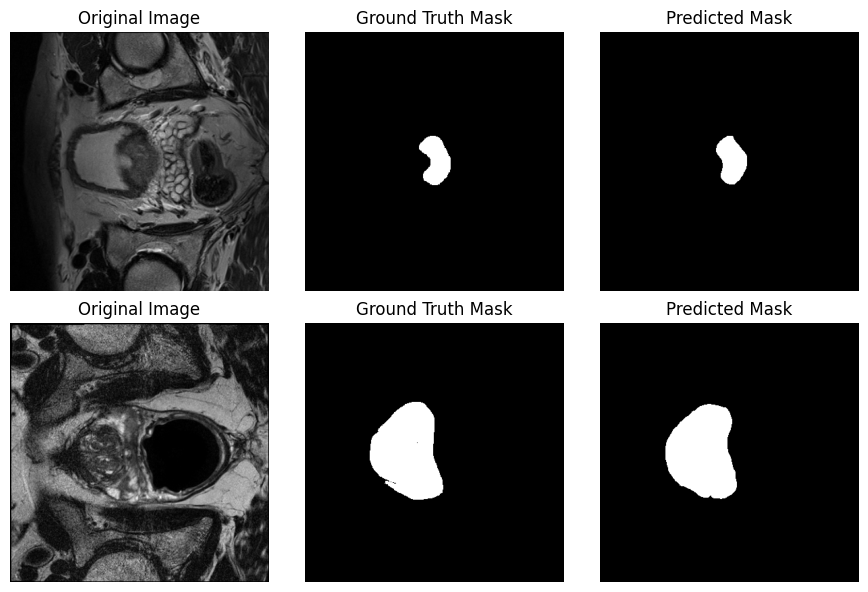

In [8]:
with torch.no_grad():  # Inference without gradient computation
    for batch in test_loader:
        images = batch['image'].to(device)
        true_masks = batch['mask'].to(device)
        preds = torch.sigmoid(model(images))
        preds = (preds > 0.5).float()  # Threshold predictions
        
        images = images.cpu()
        true_masks = true_masks.cpu()
        preds = preds.cpu()
        
        fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(9, 3 * 2))
        for i in range(2):
            ax[i, 0].imshow(images[i].squeeze(), cmap='gray')
            ax[i, 0].set_title('Original Image')
            ax[i, 0].axis('off')
            
            ax[i, 1].imshow(true_masks[i].squeeze(), cmap='gray')
            ax[i, 1].set_title('Ground Truth Mask')
            ax[i, 1].axis('off')
            
            ax[i, 2].imshow(preds[i].squeeze(), cmap='gray')
            ax[i, 2].set_title('Predicted Mask')
            ax[i, 2].axis('off')
        
        plt.tight_layout()
        plt.show()
        break